In [2]:
#%matplotlib widget
import numpy as np
import astropy.units as u
from astropy import constants as const
from astropy.io import fits
import matplotlib.pyplot as plt
from specmatchemp import spectrum
import specmatchemp.library
from specmatchemp.specmatch import SpecMatch

## Compute AMD using SpecMatch-Emp for GALAH spectra

In [3]:
# Doesn't work since GALAH doesn't cover 5140-5200 A
'''
# Load spectral library (e.g. Mg b region)
lib = specmatchemp.library.read_hdf(wavlim=[5140,5200])

# Load your observed GALAH spectrum, then crop to library wavelength range
galah_spec = spectrum.read_hires_fits('/datax/scratch/emmay/galah_spectra/161116001701343_R.fits').cut(5130, 5210)
galah_spec.name = 'MyGALAHstar'

# Initialize SpecMatch with your spectrum and the library
sm = SpecMatch(galah_spec, lib)

# Shift your spectrum to library rest wavelengths
sm.shift()

# Perform the spectral match
sm.match(wavlim=(5140,5200))

# Compute a linear combination of best matches for best fit
sm.lincomb()

# Access derived stellar parameters
print("Teff:", sm.results['Teff'])
print("Radius:", sm.results['radius'])
print("[Fe/H]:", sm.results['feh'])

# Calculate residuals between observed and best-fit model
residuals = galah_spec.flux - sm.lincomb_spectrum.flux
'''

'\n# Load spectral library (e.g. Mg b region)\nlib = specmatchemp.library.read_hdf(wavlim=[5140,5200])\n\n# Load your observed GALAH spectrum, then crop to library wavelength range\ngalah_spec = spectrum.read_hires_fits(\'/datax/scratch/emmay/galah_spectra/161116001701343_R.fits\').cut(5130, 5210)\ngalah_spec.name = \'MyGALAHstar\'\n\n# Initialize SpecMatch with your spectrum and the library\nsm = SpecMatch(galah_spec, lib)\n\n# Shift your spectrum to library rest wavelengths\nsm.shift()\n\n# Perform the spectral match\nsm.match(wavlim=(5140,5200))\n\n# Compute a linear combination of best matches for best fit\nsm.lincomb()\n\n# Access derived stellar parameters\nprint("Teff:", sm.results[\'Teff\'])\nprint("Radius:", sm.results[\'radius\'])\nprint("[Fe/H]:", sm.results[\'feh\'])\n\n# Calculate residuals between observed and best-fit model\nresiduals = galah_spec.flux - sm.lincomb_spectrum.flux\n'

Filename: /datax/scratch/emmay/galah_spectra/140708007101168_B.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     220   (4096,)   float64   
  1  normalized    1 ImageHDU       249   (4096,)   float64   
  2  relative_error    1 ImageHDU       249   (4096,)   float64   
  3  sky           1 ImageHDU       249   (4096,)   float64   
  4  teluric       1 ImageHDU       249   (4096,)   float64   
  5  scattered     1 ImageHDU       249   (4096,)   float32   
  6  cross_talk    1 ImageHDU       249   (4096,)   float64   
  7  resolution_profile    1 ImageHDU       249   (4096,)   float32   


Mean flux error: 0.051862


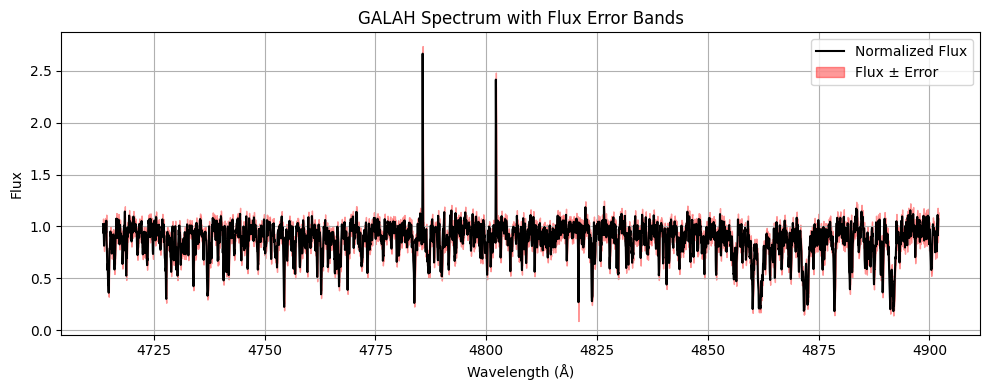

In [4]:
# === Load the GALAH FITS file ===
hdul = fits.open('/datax/scratch/emmay/galah_spectra/140708007101168_B.fits')
hdul.info()

# === Extract spectrum and relative error ===
flux = hdul[1].data                     # Normalized spectrum
rel_err = hdul[2].data                  # Relative error (fractional)

# === Get wavelength solution from header ===
hdr = hdul[1].header
crval1 = hdr['CRVAL1']                  # Starting wavelength (Å)
cdelt1 = hdr['CDELT1']                  # Wavelength increment
crpix1 = hdr['CRPIX1']                  # Reference pixel
npix = hdr['NAXIS1']                    # Number of pixels

# === Construct wavelength array ===
wavelength = crval1 + (np.arange(npix) + 1 - crpix1) * cdelt1

# === Calculate absolute error ===
abs_err = rel_err * flux

# === Compute mean flux error (ignoring NaNs if present) ===
mean_flux_error = np.nanmean(np.abs(abs_err))
print(f"Mean flux error: {mean_flux_error:.6f}")

# === Optional: Plot the flux with error bands ===
plt.figure(figsize=(10, 4))
plt.plot(wavelength, flux, label='Normalized Flux', color='black')
plt.fill_between(wavelength, flux - abs_err, flux + abs_err,
                 color='red', alpha=0.4, label='Flux ± Error')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title("GALAH Spectrum with Flux Error Bands")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
#Calculate AMD

np.nanmean(np.abs(flux-np.nanmedian(flux)))

np.float64(0.11448593637760496)

In [6]:
#Zuckerman (9)
def calc_laser_l(alpha, AMD, lambda_l, d_E, epsilon, del_t, N_obs, A_APF, d_T):
    numerator = 1.22**2*alpha*np.pi*const.h*const.c*AMD*lambda_l*d_E**2
    denominator = 4*epsilon*del_t*N_obs*A_APF*d_T**2
    return numerator/denominator

### APF Laser Detection Threshold

In [7]:
# N_obs=5?
calc_laser_l(alpha=6, AMD=414.78, lambda_l=(5000*u.AA).to(u.m), d_E=(78.47*u.lyr).to(u.m), epsilon=0.05, del_t=730*u.s, N_obs=3, A_APF=4.53*u.m**2, d_T=2.4*u.m).to('kW')

<Quantity 55.73746051 kW>

### GALAH Laser Detection Threshold

In [8]:
# These are the minimum laser powers required to detect the closest and furthest object in the GALAH catalog
closest_galah = calc_laser_l(alpha=6, AMD= 0.11448593637760496, lambda_l=(4810*u.AA).to(u.m), d_E=(0.0013*u.kpc).to(u.m), epsilon=0.28, del_t=730*u.s, N_obs=1, A_APF=np.pi*1.2*u.m**2, d_T=1.2*u.m).to('W')
furthest_galah = calc_laser_l(alpha=6, AMD= 0.11448593637760496, lambda_l=(4810*u.AA).to(u.m), d_E=(0.11931*u.kpc).to(u.m), epsilon=0.28, del_t=730*u.s, N_obs=1, A_APF=np.pi*1.2*u.m**2, d_T=1.2*u.m).to('kW')

In [9]:
closest_galah

<Quantity 0.1112623 W>

In [10]:
furthest_galah

<Quantity 0.93716276 kW>

In [11]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("catalog_summary.csv")

# Check if the column exists
if 'Dist50' in df.columns:
    # Drop missing or invalid values (if any)
    dist_values = pd.to_numeric(df['Dist50'], errors='coerce').dropna()
    
    # Print min and max
    print(f"Min Dist50: {dist_values.min()}")
    print(f"Max Dist50: {dist_values.max()}")
else:
    print("Column 'Dist50' not found in the CSV file.")

Min Dist50: 0.0013
Max Dist50: 0.11931


/tmp/ipykernel_118030/2824836022.py:4: DtypeWarning: Columns (15,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("catalog_summary.csv")


In [12]:
solar_system = calc_laser_l(alpha=6, AMD= 3.2e8, lambda_l=(4810*u.AA).to(u.m), d_E=(3*u.au).to(u.m), epsilon=0.28, del_t=730*u.s, N_obs=1, A_APF=np.pi*1.2*u.m**2, d_T=1.2*u.m).to('' \
'W')
solar_system

<Quantity 0.03892704 W>